## CACTI Radars Analysis:

**Radar data plotting and analysis test codes.**

**Hungjui Yu 20220401**

In [228]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [229]:
import sys
import time
import datetime as dt
from netCDF4 import Dataset # MFDataset
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ( from_levels_and_colors, Normalize ) 

import metpy.calc as mpcalc
from metpy.interpolate import cross_section

In [230]:
from wrf import ( getvar, interplevel, to_np, get_cartopy, latlon_coords, vertcross,
                  cartopy_xlim, cartopy_ylim, interpline, CoordPair, WrfProj )

### Open radar data:

In [231]:
data_path_1 = '/home/hyu/2scratch2/DATA_DOE_CACTI_cases'

#### from SAMURAI:

In [232]:
test_method = 'SAMURAI'
test_time = dt.datetime(2019, 1, 25, 22, 0, 0)

data_path_2_met = '/test_{}'.format(test_method)
data_path_3_dt = '/test_{}'.format(test_time.strftime('%Y%m%d_%H%M%S'))

data_path_full = data_path_1 \
               + data_path_2_met \
               + data_path_3_dt \
               + '/output/samurai_XYZ_analysis.nc'
            
ds_radar = xr.open_dataset(data_path_full)

In [233]:
ds_radar

<xarray.Dataset>
Dimensions:     (longitude: 201, latitude: 201, altitude: 51, time: 1)
Coordinates:
  * longitude   (longitude) float32 -66.56 -66.54 -66.52 ... -62.36 -62.34
  * latitude    (latitude) float32 -33.68 -33.67 -33.65 ... -30.11 -30.09 -30.08
  * altitude    (altitude) float32 0.0 0.5 1.0 1.5 2.0 ... 23.5 24.0 24.5 25.0
  * time        (time) datetime64[ns] 2019-01-25T22:00:03
Data variables: (12/53)
    x           (longitude) float32 ...
    y           (latitude) float32 ...
    U           (time, altitude, latitude, longitude) float32 ...
    V           (time, altitude, latitude, longitude) float32 ...
    W           (time, altitude, latitude, longitude) float32 ...
    WSPD        (time, altitude, latitude, longitude) float32 ...
    ...          ...
    DQVDZ       (time, altitude, latitude, longitude) float32 ...
    DPDZ        (time, altitude, latitude, longitude) float32 ...
    DRHODX      (time, altitude, latitude, longitude) float32 ...
    DRHODY      (time, altitude, latitude, longitude) float32 ...
    DRHODZ      (time, altitude, latitude, longitude) float32 ...
    MCRESIDUAL  (time, altitude, latitude, longitude) float32 ...

In [ ]:
# ds_radar.W.sel(altitude=2).plot()
# ds_radar.W.isel(altitude=4).plot()
# ds_radar.DBZ.sel(altitude=2).data[0].shape

#### from FRACTL:

#### from EVAD:

In [ ]:
# ds_radar = xr.open_dataset('/home/hyu/2scratch2/DATA_DOE_CACTI_cases/test_EVAD/output/20190125/profile.20190125_180003.CSAPR2.nc')

In [ ]:
# ds_radar

In [ ]:
# ds_radar.profile.plot()

### Plot 1: Maps:

#### Set plotting parameters:

In [ ]:
plot_alt = 2.5 #km

#### Function: Creating new map:

In [ ]:
def new_map(fig):
    
    # proj = ccrs.LambertConformal( central_longitude=0.0, central_latitude=30, globe=None )
    # proj = ccrs.LambertCylindrical( central_longitude=0.0, globe=None )
    proj = ccrs.PlateCarree( central_longitude=0, globe=None)
    
    # ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = plt.axes(projection=proj)
    
    ## Add background image:
    # ax.stock_img()
    
    ## Add Stamen terrain:
    stamen_terrain = cimgt.Stamen('terrain')
    
    ax.add_image(stamen_terrain, 8)
    
    ## Set extent:
    # ax.set_global()
    
    ## S. America:
    # ax.set_extent([-30, -90, 20, -60], crs=proj)
    ## CACTI:
    # ax.set_extent([-61.5, -67, -28.5, -34.5], crs=proj)
    ax.set_extent([-62.5, -66.5, -29.5, -33.5], crs=proj)
    # ax.set_extent([-62.5, -66, -29.5, -33.5], crs=proj)
    # ax.set_extent([-55, -75, -20, -40], crs=proj)
    
    ## Add coast lines:
    ax.coastlines('10m', 'black', linewidth=1)
    
    ## Grab state shapefile:
    state_borders = cfeat.NaturalEarthFeature( category='cultural' # 'physical'
                                             , name='admin_1_states_provinces_lines'
                                             # , name='geography_regions_elevation_points'
                                             , scale='50m'
                                             , facecolor='none'
                                             , edgecolor='gray'
                                             )
    ## Add features:
    # ax.add_feature(cfeat.BORDERS)
    # ax.add_feature(cfeat.LAND)
    # ax.add_feature(cfeat.COASTLINE)
    # ax.add_feature(cfeat.OCEAN, edgecolor=None) #, fc='none')
    # ax.add_feature(cfeat.GSHHSFeature(scale='auto', levels=None))
    # ax.add_feature(state_borders, linewidth=0.8)
    
    ## Add the gridlines:
    latlon_grid_int = 1
    ax_gl = ax.gridlines( crs=ccrs.PlateCarree()
                        , linewidth=0.5
                        , color='#454545' 
                        , alpha=0.9
                        , linestyle='--'
                        , draw_labels=True 
                        , dms=True
                        # , x_inline=False 
                        # , y_inline=False
                        , xlocs=np.arange(-180, 181, latlon_grid_int)
                        , ylocs=np.arange(-90, 91, latlon_grid_int)
                        )
    ax_gl.top_labels = False
    ax_gl.right_labels = False
    ax_gl.bottom_labels = True
    ax_gl.left_labels = True
    ax_gl.xlabel_style = {'size': 14, 'weight': 'bold'}
    ax_gl.ylabel_style = {'size': 14, 'weight': 'bold'}
    
    
    return ax

#### Plot dBZ:

In [ ]:
## Set NWS reflectivity colorbar:
from metpy.plots import ctables
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', -20, 0.5)

## Set CWB reflectivity colorbar:
clevs = [-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
ccols = ['#ffffff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']
# clevs = [-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
# ccols = ['#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']

In [ ]:
np.datetime_as_string(ds_radar.time.data[0], unit='s')

In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

plotting_var = ds_radar.DBZ.sel(altitude=plot_alt).data[0]
plotting_lon = ds_radar.longitude
plotting_lat = ds_radar.latitude


## CWB colorbar:
cf1 = ax1.contourf( plotting_lon, plotting_lat, plotting_var
                  , levels=clevs, colors=ccols
                  , alpha=0.6
                  )

## NWS colorbar:
# cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
#                     , cmap=ref_cmap, norm=ref_norm
#                     , alpha=0.8
#                     , shading='auto'
#                     )
# cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
#                     , vmax=70
#                     , vmin=-5
#                     , cmap=ctables.registry.get_colortable('NWSReflectivity')
#                     # , norm=Normalize(-5, 75)
#                     )

## Loc. CSAPR2:
plt.plot( -64.73, -32.13
        # , color='k'
        , marker='o'
        , markersize=10
        , mec='k'
        , mew=3
        , mfc='none'
        # , markevery=[0,-1]
        # , linewidth=1.0
        # , linestyle='--'
        )

## Loc. CHIVO:
plt.plot( -64.17, -31.63
        # , color='k'
        , marker='o'
        , markersize=12
        , mec='k'
        , mew=1
        , mfc='k'
        # , markevery=[0,-1]
        # , linewidth=1.0
        # , linestyle='--'
        )

cf1_title = plt.title( 'Retrieved dBZ'
                     # + test_time.strftime('%Y-%m-%d T%H:%M:%SZ') 
                     + '\n Time: ' + np.datetime_as_string(ds_radar.time.data[0], unit='s') + 'Z'
                     + ' / Height: ' + str(plot_alt) + '-km'
                     + ' \n Method: ' + test_method
                     ,fontsize=14 
                     ,fontweight='bold'
                     )

cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
cbar = fig.colorbar(cf1, cax=cbar_ax, fraction=0.04)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('[dBZ]', fontsize=12, y=-0.1)


## Save figure:

# plt.savefig('./' + np.datetime_as_string(dbz_lev.Time.data, unit='h') + '_dbz_xline.png', 
#             bbox_inches='tight', 
#             dpi=300)



#### Plot W:

In [ ]:
## W Colormap settings:
w_bounds = np.arange(-4, 4.1, 0.5)
w_cmap = cm.get_cmap('RdBu_r', w_bounds.size+1)
w_norm = mpl.colors.BoundaryNorm(w_bounds, w_cmap.N, extend='both')


In [ ]:
fig = plt.figure(figsize=(9,16))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

plotting_var = ds_radar.W.sel(altitude=2.5).data[0]
plotting_lon = ds_radar.longitude
plotting_lat = ds_radar.latitude


cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
                    , cmap=w_cmap
                    , norm=w_norm
                    , alpha=0.8
                    , shading='auto')


## Loc. CSAPR2:
plt.plot( -64.73, -32.13
        # , color='k'
        , marker='o'
        , markersize=14
        , mec='k'
        , mew=1
        , mfc='k'
        # , markevery=[0,-1]
        # , linewidth=1.0
        # , linestyle='--'
        )

## Loc. CHIVO:
plt.plot( -64.17, -31.63
        # , color='k'
        , marker='o'
        , markersize=14
        , mec='k'
        , mew=1
        , mfc='k'
        # , markevery=[0,-1]
        # , linewidth=1.0
        # , linestyle='--'
        )

## Plot cross-section lines:
plt.plot( [-63.5, -65.5], [-31.5, -33]
        , color='green'
        , marker='.'
        , markersize=14
        # , mec='k'
        # , mew=1
        # , mfc='k'
        , markevery=[0,-1]
        , linewidth=2.0
        , linestyle='--'
        )

cf1_title = plt.title( 'Retrieved W'
                     # + test_time.strftime('%Y-%m-%d T%H:%M:%SZ') 
                     + '\n Time: ' + np.datetime_as_string(ds_radar.time.data[0], unit='s') + 'Z'
                     + ' / Height: ' + str(plot_alt) + '-km'
                     + ' \n Method: ' + test_method
                     ,fontsize=14 
                     ,fontweight='bold'
                     )

cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
cbar = fig.colorbar(cf1, cax=cbar_ax, fraction=0.04)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('[m/s]', fontsize=12, y=-0.1)


## Save figure:

# plt.savefig('./' + np.datetime_as_string(dbz_lev.Time.data, unit='h') + '_dbz_xline.png', 
#             bbox_inches='tight', 
#             dpi=300)


### Plot 2: Cross-sections:

In [256]:
from metpy.cbook import get_test_data
tmp_data = xr.open_dataset(get_test_data('narr_example.nc', False))

In [257]:
tmp_data

<xarray.Dataset>
Dimensions:              (time: 1, isobaric: 29, y: 118, x: 292)
Coordinates:
  * time                 (time) datetime64[ns] 1987-04-04T18:00:00
  * isobaric             (isobaric) float64 1e+03 975.0 950.0 ... 125.0 100.0
  * y                    (y) float64 -3.087e+03 -3.054e+03 ... 678.9 711.4
  * x                    (x) float64 -3.977e+03 -3.945e+03 ... 5.47e+03
Data variables:
    Temperature          (time, isobaric, y, x) float32 ...
    Lambert_Conformal    |S1 ...
    lat                  (y, x) float64 ...
    lon                  (y, x) float64 ...
    u_wind               (time, isobaric, y, x) float32 ...
    v_wind               (time, isobaric, y, x) float32 ...
    Geopotential_height  (time, isobaric, y, x) float32 ...
    Specific_humidity    (time, isobaric, y, x) float32 ...
Attributes: (12/14)
    Conventions:              CF-1.0
    Originating_center:       US National Weather Service - NCEP(WMC) (7)
    Originating_subcenter:    The North American Regional Reanalysis (NARR) P...
    Generating_Model:         North American Regional Reanalysis (NARR)
    Product_Type:             Forecast/Uninitialized Analysis/Image Product
    title:                    US National Weather Service - NCEP(WMC) North A...
    ...                       ...
    history:                  Direct read of GRIB-1 into NetCDF-Java 4 API
    CF:feature_type:          GRID
    file_format:              GRIB-1
    location:                 /nomads3_data/raid2/noaaport/merged/narr/198704...
    _CoordinateModelRunDate:  1987-04-04T18:00:00Z
    History:                  Translated to CF-1.0 Conventions by Netcdf-Java...

In [258]:
tmp_data = tmp_data.metpy.parse_cf().squeeze()

In [312]:
tmp_data

<xarray.Dataset>
Dimensions:              (isobaric: 29, y: 118, x: 292)
Coordinates:
    time                 datetime64[ns] 1987-04-04T18:00:00
  * isobaric             (isobaric) float64 1e+03 975.0 950.0 ... 125.0 100.0
  * y                    (y) float64 -3.087e+06 -3.054e+06 ... 7.114e+05
  * x                    (x) float64 -3.977e+06 -3.945e+06 ... 5.47e+06
    crs                  object Projection: lambert_conformal_conic
Data variables:
    Temperature          (isobaric, y, x) float32 ...
    Lambert_Conformal    |S1 b'd'
    lat                  (y, x) float64 16.07 16.18 16.28 ... 34.22 34.0 33.79
    lon                  (y, x) float64 -140.0 -139.7 -139.5 ... -42.28 -42.07
    u_wind               (isobaric, y, x) float32 ...
    v_wind               (isobaric, y, x) float32 ...
    Geopotential_height  (isobaric, y, x) float32 ...
    Specific_humidity    (isobaric, y, x) float32 ...
Attributes: (12/14)
    Conventions:              CF-1.0
    Originating_center:       US National Weather Service - NCEP(WMC) (7)
    Originating_subcenter:    The North American Regional Reanalysis (NARR) P...
    Generating_Model:         North American Regional Reanalysis (NARR)
    Product_Type:             Forecast/Uninitialized Analysis/Image Product
    title:                    US National Weather Service - NCEP(WMC) North A...
    ...                       ...
    history:                  Direct read of GRIB-1 into NetCDF-Java 4 API
    CF:feature_type:          GRID
    file_format:              GRIB-1
    location:                 /nomads3_data/raid2/noaaport/merged/narr/198704...
    _CoordinateModelRunDate:  1987-04-04T18:00:00Z
    History:                  Translated to CF-1.0 Conventions by Netcdf-Java...

In [260]:
tmp_start = (37.0, -105.0)
tmp_end = (35.5, -65.0)
tmp_cross = cross_section(tmp_data, tmp_start, tmp_end).set_coords(('lat', 'lon'))
tmp_cross

<xarray.Dataset>
Dimensions:              (isobaric: 29, index: 100)
Coordinates:
    time                 datetime64[ns] 1987-04-04T18:00:00
  * isobaric             (isobaric) float64 1e+03 975.0 950.0 ... 125.0 100.0
    crs                  object Projection: lambert_conformal_conic
    x                    (index) float64 1.818e+05 2.18e+05 ... 3.712e+06
    y                    (index) float64 -1.454e+06 -1.447e+06 ... -5.573e+05
  * index                (index) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    lat                  (index) float64 37.0 37.05 37.11 ... 35.66 35.58 35.5
    lon                  (index) float64 -105.0 -104.6 -104.2 ... -65.39 -65.0
Data variables:
    Temperature          (isobaric, index) float64 287.7 286.9 ... 211.4 211.4
    Lambert_Conformal    |S1 b'd'
    u_wind               (isobaric, index) float64 -2.729 0.4776 ... 24.6 23.68
    v_wind               (isobaric, index) float64 8.473 5.723 ... -1.082
    Geopotential_height  (isobaric, index) float64 118.6 127.4 ... 1.636e+04
    Specific_humidity    (isobaric, index) float64 0.006367 ... 4.223e-06
Attributes: (12/14)
    Conventions:              CF-1.0
    Originating_center:       US National Weather Service - NCEP(WMC) (7)
    Originating_subcenter:    The North American Regional Reanalysis (NARR) P...
    Generating_Model:         North American Regional Reanalysis (NARR)
    Product_Type:             Forecast/Uninitialized Analysis/Image Product
    title:                    US National Weather Service - NCEP(WMC) North A...
    ...                       ...
    history:                  Direct read of GRIB-1 into NetCDF-Java 4 API
    CF:feature_type:          GRID
    file_format:              GRIB-1
    location:                 /nomads3_data/raid2/noaaport/merged/narr/198704...
    _CoordinateModelRunDate:  1987-04-04T18:00:00Z
    History:                  Translated to CF-1.0 Conventions by Netcdf-Java...

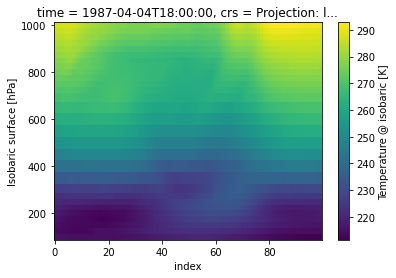

In [261]:
tmp_cross.Temperature.plot()

#### Organize dataset:

In [306]:
ds_radar_re=ds_radar
ds_radar_re

<xarray.Dataset>
Dimensions:     (longitude: 201, latitude: 201, altitude: 51, time: 1)
Coordinates:
  * longitude   (longitude) float32 -66.56 -66.54 -66.52 ... -62.36 -62.34
  * latitude    (latitude) float32 -33.68 -33.67 -33.65 ... -30.11 -30.09 -30.08
  * altitude    (altitude) float32 0.0 0.5 1.0 1.5 2.0 ... 23.5 24.0 24.5 25.0
  * time        (time) datetime64[ns] 2019-01-25T22:00:03
Data variables: (12/53)
    x           (longitude) float32 -200.0 -198.0 -196.0 ... 196.0 198.0 200.0
    y           (latitude) float32 -200.0 -198.0 -196.0 ... 196.0 198.0 200.0
    U           (time, altitude, latitude, longitude) float32 ...
    V           (time, altitude, latitude, longitude) float32 ...
    W           (time, altitude, latitude, longitude) float32 ...
    WSPD        (time, altitude, latitude, longitude) float32 ...
    ...          ...
    DQVDZ       (time, altitude, latitude, longitude) float32 ...
    DPDZ        (time, altitude, latitude, longitude) float32 ...
    DRHODX      (time, altitude, latitude, longitude) float32 ...
    DRHODY      (time, altitude, latitude, longitude) float32 ...
    DRHODZ      (time, altitude, latitude, longitude) float32 ...
    MCRESIDUAL  (time, altitude, latitude, longitude) float32 ...

In [307]:
ds_radar_re = ds_radar_re.set_coords(['x', 'y'])
ds_radar_re

<xarray.Dataset>
Dimensions:     (longitude: 201, latitude: 201, altitude: 51, time: 1)
Coordinates:
  * longitude   (longitude) float32 -66.56 -66.54 -66.52 ... -62.36 -62.34
  * latitude    (latitude) float32 -33.68 -33.67 -33.65 ... -30.11 -30.09 -30.08
    x           (longitude) float32 -200.0 -198.0 -196.0 ... 196.0 198.0 200.0
    y           (latitude) float32 -200.0 -198.0 -196.0 ... 196.0 198.0 200.0
  * altitude    (altitude) float32 0.0 0.5 1.0 1.5 2.0 ... 23.5 24.0 24.5 25.0
  * time        (time) datetime64[ns] 2019-01-25T22:00:03
Data variables: (12/51)
    U           (time, altitude, latitude, longitude) float32 ...
    V           (time, altitude, latitude, longitude) float32 ...
    W           (time, altitude, latitude, longitude) float32 ...
    WSPD        (time, altitude, latitude, longitude) float32 ...
    RH          (time, altitude, latitude, longitude) float32 ...
    HP          (time, altitude, latitude, longitude) float32 ...
    ...          ...
    DQVDZ       (time, altitude, latitude, longitude) float32 ...
    DPDZ        (time, altitude, latitude, longitude) float32 ...
    DRHODX      (time, altitude, latitude, longitude) float32 ...
    DRHODY      (time, altitude, latitude, longitude) float32 ...
    DRHODZ      (time, altitude, latitude, longitude) float32 ...
    MCRESIDUAL  (time, altitude, latitude, longitude) float32 ...

In [308]:
ds_radar_re = ds_radar_re.swap_dims({'longitude': 'x', 'latitude': 'y'})
ds_radar_re

<xarray.Dataset>
Dimensions:     (x: 201, y: 201, altitude: 51, time: 1)
Coordinates:
    longitude   (x) float32 -66.56 -66.54 -66.52 -66.5 ... -62.38 -62.36 -62.34
    latitude    (y) float32 -33.68 -33.67 -33.65 -33.63 ... -30.11 -30.09 -30.08
  * x           (x) float32 -200.0 -198.0 -196.0 -194.0 ... 196.0 198.0 200.0
  * y           (y) float32 -200.0 -198.0 -196.0 -194.0 ... 196.0 198.0 200.0
  * altitude    (altitude) float32 0.0 0.5 1.0 1.5 2.0 ... 23.5 24.0 24.5 25.0
  * time        (time) datetime64[ns] 2019-01-25T22:00:03
Data variables: (12/51)
    U           (time, altitude, y, x) float32 ...
    V           (time, altitude, y, x) float32 ...
    W           (time, altitude, y, x) float32 ...
    WSPD        (time, altitude, y, x) float32 ...
    RH          (time, altitude, y, x) float32 ...
    HP          (time, altitude, y, x) float32 ...
    ...          ...
    DQVDZ       (time, altitude, y, x) float32 ...
    DPDZ        (time, altitude, y, x) float32 ...
    DRHODX      (time, altitude, y, x) float32 ...
    DRHODY      (time, altitude, y, x) float32 ...
    DRHODZ      (time, altitude, y, x) float32 ...
    MCRESIDUAL  (time, altitude, y, x) float32 ...

In [309]:
lat, lon = np.meshgrid(ds_radar_re.latitude, ds_radar_re.longitude)

In [310]:
ds_radar_re = ds_radar_re.assign({ 'lon': (('y', 'x'), lon)
                                 , 'lat': (('y', 'x'), lat)
                                 }
                                )
ds_radar_re

<xarray.Dataset>
Dimensions:     (x: 201, y: 201, altitude: 51, time: 1)
Coordinates:
    longitude   (x) float32 -66.56 -66.54 -66.52 -66.5 ... -62.38 -62.36 -62.34
    latitude    (y) float32 -33.68 -33.67 -33.65 -33.63 ... -30.11 -30.09 -30.08
  * x           (x) float32 -200.0 -198.0 -196.0 -194.0 ... 196.0 198.0 200.0
  * y           (y) float32 -200.0 -198.0 -196.0 -194.0 ... 196.0 198.0 200.0
  * altitude    (altitude) float32 0.0 0.5 1.0 1.5 2.0 ... 23.5 24.0 24.5 25.0
  * time        (time) datetime64[ns] 2019-01-25T22:00:03
Data variables: (12/53)
    U           (time, altitude, y, x) float32 ...
    V           (time, altitude, y, x) float32 ...
    W           (time, altitude, y, x) float32 ...
    WSPD        (time, altitude, y, x) float32 ...
    RH          (time, altitude, y, x) float32 ...
    HP          (time, altitude, y, x) float32 ...
    ...          ...
    DRHODX      (time, altitude, y, x) float32 ...
    DRHODY      (time, altitude, y, x) float32 ...
    DRHODZ      (time, altitude, y, x) float32 ...
    MCRESIDUAL  (time, altitude, y, x) float32 ...
    lon         (y, x) float32 -66.56 -66.56 -66.56 ... -62.34 -62.34 -62.34
    lat         (y, x) float32 -33.68 -33.67 -33.65 ... -30.11 -30.09 -30.08

In [311]:
ds_radar_re = ds_radar_re.reset_coords(['longitude', 'latitude'])
ds_radar_re = ds_radar_re.drop(['longitude', 'latitude'])

In [313]:
ds_radar_re['crs'] = tmp_data.crs

In [315]:
ds_radar_re = ds_radar_re.set_coords(['crs'])
ds_radar_re

<xarray.Dataset>
Dimensions:     (x: 201, y: 201, altitude: 51, time: 1)
Coordinates:
  * x           (x) float32 -200.0 -198.0 -196.0 -194.0 ... 196.0 198.0 200.0
  * y           (y) float32 -200.0 -198.0 -196.0 -194.0 ... 196.0 198.0 200.0
  * altitude    (altitude) float32 0.0 0.5 1.0 1.5 2.0 ... 23.5 24.0 24.5 25.0
  * time        (time) datetime64[ns] 2019-01-25T22:00:03
    crs         object Projection: lambert_conformal_conic
Data variables: (12/53)
    U           (time, altitude, y, x) float32 ...
    V           (time, altitude, y, x) float32 ...
    W           (time, altitude, y, x) float32 ...
    WSPD        (time, altitude, y, x) float32 ...
    RH          (time, altitude, y, x) float32 ...
    HP          (time, altitude, y, x) float32 ...
    ...          ...
    DRHODX      (time, altitude, y, x) float32 ...
    DRHODY      (time, altitude, y, x) float32 ...
    DRHODZ      (time, altitude, y, x) float32 ...
    MCRESIDUAL  (time, altitude, y, x) float32 ...
    lon         (y, x) float32 -66.56 -66.56 -66.56 ... -62.34 -62.34 -62.34
    lat         (y, x) float32 -33.68 -33.67 -33.65 ... -30.11 -30.09 -30.08

In [316]:
ds_radar_re = ds_radar_re.metpy.parse_cf().squeeze()
ds_radar_re

<xarray.Dataset>
Dimensions:     (x: 201, y: 201, altitude: 51)
Coordinates:
  * x           (x) float32 -2e+05 -1.98e+05 -1.96e+05 ... 1.98e+05 2e+05
  * y           (y) float32 -2e+05 -1.98e+05 -1.96e+05 ... 1.98e+05 2e+05
  * altitude    (altitude) float32 0.0 0.5 1.0 1.5 2.0 ... 23.5 24.0 24.5 25.0
    time        datetime64[ns] 2019-01-25T22:00:03
    crs         object Projection: lambert_conformal_conic
Data variables: (12/53)
    U           (altitude, y, x) float32 ...
    V           (altitude, y, x) float32 ...
    W           (altitude, y, x) float32 ...
    WSPD        (altitude, y, x) float32 ...
    RH          (altitude, y, x) float32 ...
    HP          (altitude, y, x) float32 ...
    ...          ...
    DRHODX      (altitude, y, x) float32 ...
    DRHODY      (altitude, y, x) float32 ...
    DRHODZ      (altitude, y, x) float32 ...
    MCRESIDUAL  (altitude, y, x) float32 ...
    lon         (y, x) float32 -66.56 -66.56 -66.56 ... -62.34 -62.34 -62.34
    lat         (y, x) float32 -33.68 -33.67 -33.65 ... -30.11 -30.09 -30.08

In [317]:
data_plot=ds_radar_re #.reset_coords(['longitude', 'latitude']) #.swap_dims({'x': 'longitude','y': 'latitude'})
data_plot

<xarray.Dataset>
Dimensions:     (x: 201, y: 201, altitude: 51)
Coordinates:
  * x           (x) float32 -2e+05 -1.98e+05 -1.96e+05 ... 1.98e+05 2e+05
  * y           (y) float32 -2e+05 -1.98e+05 -1.96e+05 ... 1.98e+05 2e+05
  * altitude    (altitude) float32 0.0 0.5 1.0 1.5 2.0 ... 23.5 24.0 24.5 25.0
    time        datetime64[ns] 2019-01-25T22:00:03
    crs         object Projection: lambert_conformal_conic
Data variables: (12/53)
    U           (altitude, y, x) float32 ...
    V           (altitude, y, x) float32 ...
    W           (altitude, y, x) float32 ...
    WSPD        (altitude, y, x) float32 ...
    RH          (altitude, y, x) float32 ...
    HP          (altitude, y, x) float32 ...
    ...          ...
    DRHODX      (altitude, y, x) float32 ...
    DRHODY      (altitude, y, x) float32 ...
    DRHODZ      (altitude, y, x) float32 ...
    MCRESIDUAL  (altitude, y, x) float32 ...
    lon         (y, x) float32 -66.56 -66.56 -66.56 ... -62.34 -62.34 -62.34
    lat         (y, x) float32 -33.68 -33.67 -33.65 ... -30.11 -30.09 -30.08

In [320]:
start = (-63, -31)
end = (-66, -33)
# start = (-50000, -50000)
# end = (50000, 50000)
radar_cross = cross_section(data_plot, start, end)#.set_coords(('lon', 'lat'))
radar_cross

<xarray.Dataset>
Dimensions:     (altitude: 51, index: 100)
Coordinates:
  * altitude    (altitude) float32 0.0 0.5 1.0 1.5 2.0 ... 23.5 24.0 24.5 25.0
    time        datetime64[ns] 2019-01-25T22:00:03
    crs         object Projection: lambert_conformal_conic
    x           (index) float64 2.939e+07 2.941e+07 ... 3.169e+07 3.171e+07
    y           (index) float64 -1.286e+07 -1.289e+07 ... -1.547e+07 -1.55e+07
  * index       (index) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Data variables: (12/53)
    U           (altitude, index) float64 nan nan nan nan ... nan nan nan nan
    V           (altitude, index) float64 nan nan nan nan ... nan nan nan nan
    W           (altitude, index) float64 nan nan nan nan ... nan nan nan nan
    WSPD        (altitude, index) float64 nan nan nan nan ... nan nan nan nan
    RH          (altitude, index) float64 nan nan nan nan ... nan nan nan nan
    HP          (altitude, index) float64 nan nan nan nan ... nan nan nan nan
    ...          ...
    DRHODX      (altitude, index) float64 nan nan nan nan ... nan nan nan nan
    DRHODY      (altitude, index) float64 nan nan nan nan ... nan nan nan nan
    DRHODZ      (altitude, index) float64 nan nan nan nan ... nan nan nan nan
    MCRESIDUAL  (altitude, index) float64 nan nan nan nan ... nan nan nan nan
    lon         (index) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    lat         (index) float64 nan nan nan nan nan nan ... nan nan nan nan nan

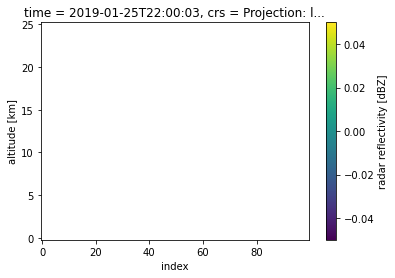

In [321]:
radar_cross.DBZ.plot()

### <font color='teal'>**Supplement Codes:**</font>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from astropy.convolution import convolve, Gaussian2DKernel
import pyart
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                            csu_dsd, csu_kdp, csu_misc, fundamentals)
import csu_radartools
import matplotlib.colors as colors
import difflib
import os
from datetime import datetime


In [ ]:
print (csu_radartools.__version__)

In [ ]:
def two_panel_plot(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=70,
                   cmap1='pyart_HomeyerRainbow', units1='dBZ', var2='differential_reflectivity',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='dB', return_flag=False,
                   xlim=[-150,150], ylim=[-150,150]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(18,5))
    fig.patch.set_facecolor('xkcd:white')
    ax1 = fig.add_subplot(121)
    display.plot_rhi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_rhi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    if return_flag:
        return fig, ax1, ax2, display

In [ ]:
#radarfile = '/home/mrocque/research/relampago/csapr2/corcsapr2cfrppiqcM1.b1.20181214.030003.custom.nc2'
radarfile = '/home/mrocque/research/relampago/csapr2/corcsapr2cfrppiqcM1.b1.20181214.140003.custom.nc1'
#radarfile = '/rasmussen-scratch/krasmussen/DATA/RELAMPAGO/CSAPR2/ppi/20181214/corcsapr2cfrppiqcM1.b1.20181214.141504.custom.nc'
#radarfile = '/rasmussen-scratch/krasmussen/DATA/RELAMPAGO/CSAPR2/ppi/20181214/corcsapr2cfrppiqcM1.b1.20181214.234504.custom.nc'
#radarfile = '/home/mrocque/research/relampago/csapr2/corcsapr2cfrhsrhiqcM1.b1.20181214.030715.custom.nc2'
radar = pyart.io.read(radarfile)
print(radar.fields.keys())

dz = radar.fields['DZ_qc']['data']
dr = radar.fields['ZDR_qc']['data']
kd = radar.fields['PHIDP_qc']['data']
rh = radar.fields['RHOHV_qc']['data']

In [ ]:
del radar.fields['uncorrected_reflectivity_v']

In [ ]:
print (radar.fields.keys())

In [ ]:
snd_times = []
filenames = []
for filename in os.listdir('/rasmussen-scratch/mrocque/research/relampago/CACTI_ARM_soundings/netcdf/'):
    filenames.append(filename)
    str2 = (filename[18:33])
    snd_times.append(datetime.strptime(str2, '%Y%m%d.%H%M%S'))


In [ ]:
filenames.sort()
snd_times.sort()

In [ ]:
print (snd_times)

In [ ]:
#str1 = radarfile[63:78]
str1 = radarfile[88:103]
print (str1)

#closest = difflib.get_close_matches(str1, snd_times, 1)
#print (snd_times.index(closest[0]))

In [ ]:
dt_obj = datetime.strptime(str1, '%Y%m%d.%H%M%S')

res = min(snd_times, key=lambda sub: abs(sub - dt_obj))


In [ ]:
print (dt_obj)

In [ ]:
print (res)
print (snd_times.index(res))

In [ ]:
print (filenames[339])

In [ ]:
#584
#707

print (filenames[340])

In [ ]:
sndfile = '/rasmussen-scratch/mrocque/research/relampago/CACTI_ARM_soundings/netcdf/corsondewnpnM1.b1.20181214.000000.custom.cdf'

data = Dataset(sndfile, 'r')
print (data.variables.keys())
temp = np.array(data.variables['tdry'])
hght = np.array(data.variables['alt'])

In [ ]:
print (data.variables['base_time'])

In [ ]:
def radar_coords_to_cart(rng, az, ele, debug=False):
    """
    TJL - taken from old Py-ART version
    Calculate Cartesian coordinate from radar coordinates
    Parameters
    ----------
    rng : array
        Distances to the center of the radar gates (bins) in kilometers.
    az : array
        Azimuth angle of the radar in degrees.
    ele : array
        Elevation angle of the radar in degrees.
    Returns
    -------
    x, y, z : array
        Cartesian coordinates in meters from the radar.
    Notes
    -----
    The calculation for Cartesian coordinate is adapted from equations
    2.28(b) and 2.28(c) of Doviak and Zrnic [1]_ assuming a
    standard atmosphere (4/3 Earth's radius model).
    .. math::
        z = \\sqrt{r^2+R^2+r*R*sin(\\theta_e)} - R
        s = R * arcsin(\\frac{r*cos(\\theta_e)}{R+z})
        x = s * sin(\\theta_a)
        y = s * cos(\\theta_a)
    Where r is the distance from the radar to the center of the gate,
    :math:\\theta_a is the azimuth angle, :math:\\theta_e is the
    elevation angle, s is the arc length, and R is the effective radius
    of the earth, taken to be 4/3 the mean radius of earth (6371 km).
    References
    ----------
    .. [1] Doviak and Zrnic, Doppler Radar and Weather Observations, Second
        Edition, 1993, p. 21.
    """
    theta_e = ele * np.pi / 180.0  # elevation angle in radians.
    theta_a = az * np.pi / 180.0  # azimuth angle in radians.
    R = 6371.0 * 1000.0 * 4.0 / 3.0  # effective radius of earth in meters.
    r = rng * 1000.0  # distances to gates in meters.

    z = (r ** 2 + R ** 2 + 2.0 * r * R * np.sin(theta_e)) ** 0.5 - R
    s = R * np.arcsin(r * np.cos(theta_e) / (R + z))  # arc length in m.
    x = s * np.sin(theta_a)
    y = s * np.cos(theta_a)
    return x, y, z


def get_z_from_radar(radar):
    """Input radar object, return z from radar (km, 2D)"""
    azimuth_1D = radar.azimuth['data']
    elevation_1D = radar.elevation['data']
    srange_1D = radar.range['data']
    sr_2d, az_2d = np.meshgrid(srange_1D, azimuth_1D)
    el_2d = np.meshgrid(srange_1D, elevation_1D)[1]
    xx, yy, zz = radar_coords_to_cart(sr_2d/1000.0, az_2d, el_2d)
    return zz + radar.altitude['data']

def check_sounding_for_montonic(sounding):
    """
    So the sounding interpolation doesn't fail, force the sounding to behave
    monotonically so that z always increases. This eliminates data from
    descending balloons.
    """
    snd_T = np.array(sounding.variables['tdry'])
    snd_z = np.array(sounding.variables['alt'])
    
    #snd_T = sounding.soundingdata['temp']  # In old SkewT, was sounding.data
    #snd_z = sounding.soundingdata['hght']  # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    #if not snd_T.mask[0]: #May cause issue for specific soundings
    dummy_z.append(snd_z[0])
    dummy_T.append(snd_T[0])
    for i, height in enumerate(snd_z):
        if i > 0:
            if snd_z[i] > snd_z[i-1]:# and not snd_T.mask[i]:
                dummy_z.append(snd_z[i])
                dummy_T.append(snd_T[i])
    snd_z = np.array(dummy_z)
    snd_T = np.array(dummy_T)
    return snd_T, snd_z


def interpolate_sounding_to_radar(sounding, radar):
    """Takes sounding data and interpolates it to every radar gate."""
    radar_z = get_z_from_radar(radar)
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    shape = np.shape(radar_z)
    rad_z1d = radar_z.ravel()
    rad_T1d = np.interp(rad_z1d, snd_z, snd_T)
    return np.reshape(rad_T1d, shape), radar_z


In [ ]:
radar_T, radar_z = interpolate_sounding_to_radar(data, radar)

In [ ]:
scores = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True, band='C',
                                T=radar_T, method='hybrid')#, use_trap=True)

fh = np.argmax(scores, axis=0) + 1

In [ ]:
def add_field_to_radar_object(field, radar, field_name='HID_hyb', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='DZ_qc'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

In [ ]:
radar = add_field_to_radar_object(fh, radar)


In [ ]:
hid_colors = ['White', 'LightBlue', 'MediumBlue', 'DarkOrange', 'LightPink',
              'Cyan', 'DarkGray', 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphid = colors.ListedColormap(hid_colors)
cmapmeth = colors.ListedColormap(hid_colors[0:6])
cmapmeth_trop = colors.ListedColormap(hid_colors[0:7])

def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.4, 10, 0.9))
    cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                           'Wet Snow', 'Vertical Ice', 'LD Graupel',
                           'HD Graupel', 'Hail', 'Big Drops'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

def adjust_meth_colorbar_for_pyart(cb, tropical=False):
    if not tropical:
        cb.set_ticks(np.arange(1.25, 5, 0.833))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z)', 'R(Zrain)'])
    else:
        cb.set_ticks(np.arange(1.3, 6, 0.85))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z_all)', 'R(Z_c)', 'R(Z_s)'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

In [ ]:
# Actual plotting done here
lim = [0, 100]
lim2 = [0, 20]
fig, ax1, ax2, display = two_panel_plot(
    radar, sweep=3, var1='DZ_qc', vmin1=0, vmax1=70, var2='HID_hyb', vmin2=0, vmax2=10,
    cmap2=cmaphid, units2='', return_flag=True, xlim=lim, ylim=lim2)
display.cbs[1] = adjust_fhc_colorbar_for_pyart(display.cbs[1])

#plt.savefig('caspr2_20181214_030715_30rhi_hid_hyb.png', dpi=400, bbox_inches='tight')

In [ ]:
plt.plot(temp, hght)
plt.xlim(-10, 10)